In [1]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB5, EfficientNetB4, EfficientNetB7, VGG16
import tensorflow_datasets as tfds
from tensorflow.keras.metrics import Recall


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten

import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import glob
from PIL import Image
import cv2
from tqdm import tqdm

from io import BytesIO




In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/Deep_learning.zip"  # Modifier avec votre chemin réel

import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/Deep_learning.zip"
extract_path = "/content/data"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")

Extraction terminée !


In [ ]:
# Image size for resizing
img_size = 224
# Labels for image categories
labels = ['0', '1']

def loading_data(data_dir):
    data = []
    labels_list = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            if img_arr is not None:  # Check if the image was read successfully
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image
                data.append(resized_arr)
                labels_list.append(class_num)
            else:
                print(f"Warning: Unable to read image {img_path}")

    return np.array(data), np.array(labels_list)

# Load data for training, testing, and validation
train_data, train_labels = loading_data('/content/data/Deep_learning/train')
test_data, test_labels = loading_data('/content/data/Deep_learning/test')
valid_data, valid_labels = loading_data('/content/data/Deep_learning/valid')


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.


In [ ]:
# Normalize the data
X_train = np.array(train_data) / 255
X_test = np.array(test_data) / 255
X_valid = np.array(valid_data) / 255

In [ ]:
img_size = 224

# Reshape the grayscale images to 128x128x1
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)
X_valid = X_valid.reshape(-1, img_size, img_size, 1)

# Convert grayscale to RGB by duplicating the single channel 3 times
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)
X_valid = np.repeat(X_valid, 3, axis=-1)

# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_valid = np.array(valid_labels)

print(X_train.shape)  # This should now show (num_samples, 128, 128, 3)
print(X_test.shape)
print(X_valid.shape)

(2372, 224, 224, 3)
(336, 224, 224, 3)
(675, 224, 224, 3)


In [ ]:
# Concatenate training and validation sets
X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)

val_size = 0.2

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=val_size, random_state=21)

# Check the shapes
print("Training data shape:", X_train_split.shape)
print("Validation data shape:", X_val_split.shape)
print("Training labels shape:", y_train_split.shape)
print("Validation labels shape:", y_val_split.shape)

Training data shape: (2437, 224, 224, 3)
Validation data shape: (610, 224, 224, 3)
Training labels shape: (2437,)
Validation labels shape: (610,)


In [ ]:
# Performing Data Augmentation
data_generator = ImageDataGenerator(
                    rotation_range = 30,
                    zoom_range = 0.2,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    horizontal_flip = True,
                    shear_range=0.2,
                    fill_mode='nearest',
                 )


data_generator.fit(X_train)

In [ ]:
# Define the input shape
input_shape = (224, 224, 3)  # Directly using RGB input

# Load MobileNet with pre-trained weights, specifying the input shape and without the top classification layers
mobilenet_base = EfficientNetB4(input_shape=input_shape, include_top=False, weights='imagenet')

# Add Global Average Pooling to reduce dimensionality
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# x = Dense(96,activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dense(96, activation='relu', kernel_regularizer=l2(0.1))(x)  # Increased regularization
x = BatchNormalization()(x)  # Added batch normalization
x = Dropout(0.5)(x)
# Add the final Dense layer for binary classification
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1))(x)
# output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.05))(x)

# Create the final model
model = Model(inputs=mobilenet_base.input, outputs=output_layer)

# Compile the model
# optimizer = Adam(learning_rate=0.001)
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'recall'])

# Callbacks
callbacks = [
ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_recall', mode='max'),
ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
# Show model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,846,432 (68.08 MB)

 Trainable params: 17,721,033 (67.60 MB)

 Non-trainable params: 125,399 (489.84 KB)

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = model.fit(X_train_split, y_train_split, epochs=75,
          validation_data=data_generator.flow(X_val_split, y_val_split),
          batch_size=64, class_weight=class_weights,
          callbacks=callbacks)

Epoch 1/75
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5269 - loss: 18.8799 - recall: 0.5342   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.5274 - loss: 18.8663 - recall: 0.5353 - val_accuracy: 0.3443 - val_loss: 17.0366 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/75
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 784ms/step - accuracy: 0.5644 - loss: 16.6747 - recall: 0.6263 - val_accuracy: 0.6443 - val_loss: 15.1378 - val_recall: 0.0333 - learning_rate: 1.0000e-04
Epoch 3/75
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 782ms/step - accuracy: 0.5737 - loss: 14.8246 - recall: 0.6632 - val_accuracy: 0.3672 - val_loss: 13.5460 - val_recall: 0.9476 - learning_rate: 1.0000e-04
Epoch 4/75
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 776ms/step - accuracy: 0.6081 - loss: 13.2322 - recall: 0.6921 - val_accuracy: 0.4262 - val_loss: 12.1353 - val_recall: 0.8048 - learning_rate: 1.0000e-04
Epoch 5/75
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 774ms/step - accuracy: 0.6237 - loss: 11.8055 - recall: 0.7067 - val_accuracy: 0.3705 - val_loss: 10.9150 - val_recall: 0.8333 - learning_rate: 1.0000e-04
Epoch 6/75
39/39 ━━━━━━━━━━━

In [ ]:
X_test.shape

(336, 224, 224, 3)

In [ ]:
test_loss, test_acc, test_recall = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 904ms/step - accuracy: 0.7479 - loss: 0.8271 - recall: 0.0981
Test accuracy: 0.5922619104385376
Test recall: 0.2109375


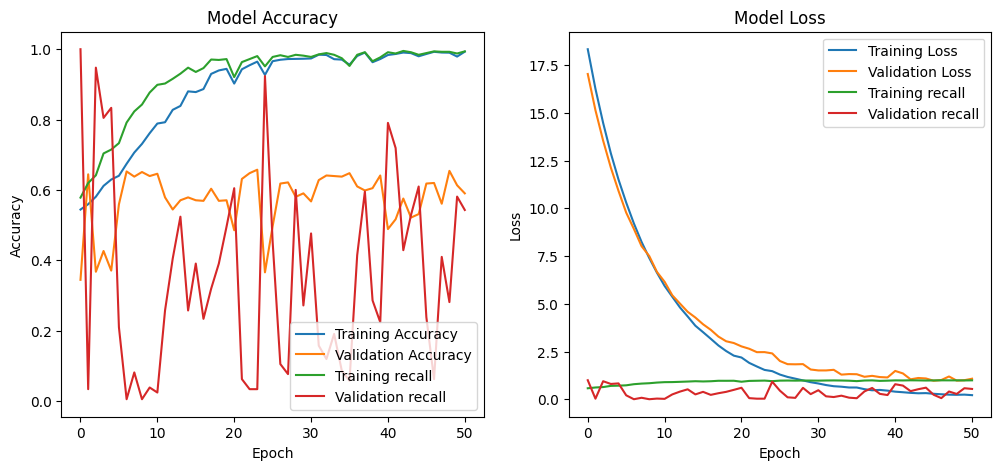

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')


plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import files
files.download('/content/best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Utilisation de edRVFL**

In [ ]:
zip_path = "/content/Deep_learning.zip"  # Modifier avec votre chemin réel

import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/Deep_learning.zip"
extract_path = "/content/data"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")

Extraction terminée !


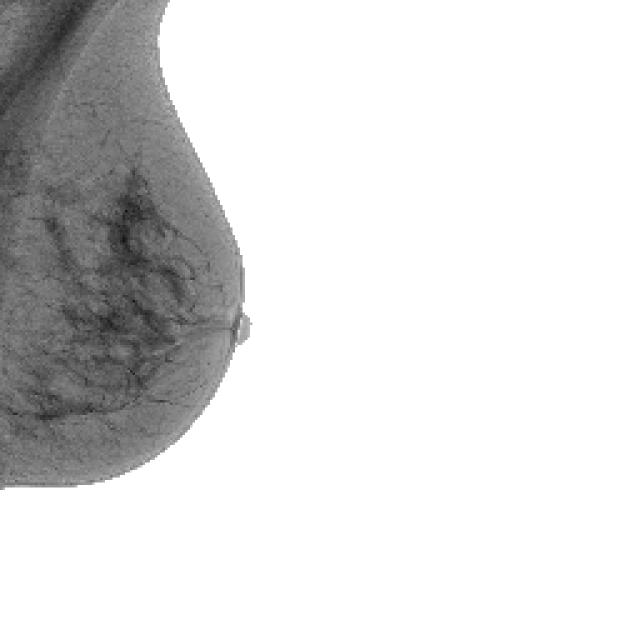

In [ ]:
load_img("/content/data/Deep_learning/train/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg")

In [ ]:
# Load and preprocess the dataset

def load_data(image_dir, img_size):
  for img in os.listdir(path):
    datagen = ImageDataGenerator(rescale=1./255)
    data = datagen.flow_from_directory(image_dir, target_size=img_size, class_mode='binary', shuffle=True)
    images, labels = next(data)
    for _ in range(len(data) - 1):
        img_batch, lbl_batch = next(data)
        images = np.concatenate((images, img_batch))
        labels = np.concatenate((labels, lbl_batch))
    return images, labels

# Feature extraction using pre-trained VGG16
def extract_features(images, img_size):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
    features = base_model.predict(images)
    features = features.reshape(features.shape[0], -1)  # Flatten features
    return features


# Define edRVFL model
def edRVFL(input_dim, num_classes, num_layers=10, hidden_units=100):
    inputs = Input(shape=(input_dim,))
    hidden_layers = []
    for _ in range(num_layers):
        random_weights = np.random.randn(input_dim, hidden_units)
        hidden_output = Dense(hidden_units, activation='relu', trainable=False, weights=[random_weights, np.zeros(hidden_units)])(inputs)
        hidden_layers.append(hidden_output)
    concatenated = Flatten()(hidden_layers)
    outputs = Dense(num_classes, activation='sigmoid')(concatenated)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:

# Image size for resizing
img_size = (224, 224)# Labels for image categories
labels = ['0', '1']
num_classes = len(labels)


# Load and preprocess data modifié pour coller à
train_image, train_labels = load_data('/content/data/Deep_learning/train', img_size)
test_image, test_labels = load_data('/content/data/Deep_learning/test', img_size)
valid_image, valid_labels = load_data('/content/data/Deep_learning/valid', img_size)

# mix
X_train = np.concatenate((train_image, valid_image), axis=0)
y_train = np.concatenate((train_labels, valid_labels), axis=0)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Feature extraction
X_train_features = extract_features(X_train, img_size)
X_val_features = extract_features(X_val, img_size)
# Initialize and compile edRVFL model
input_dim = X_train_features.shape[1]
model = edRVFL(input_dim, num_classes)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
model.fit(X_train_features, y_train, epochs=10, batch_size=32, validation_data=(X_val_features, y_val))
# Evaluate the model
y_pred = model.predict(X_val_features)
print(classification_report(y_val, np.argmax(y_pred, axis=1)))

UnboundLocalError: cannot access local variable 'labels' where it is not associated with a value

# nouveau dataset

In [4]:
data_dir = "/content/tensorflow_datasets"

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os

class CustomImageDataset(tfds.core.GeneratorBasedBuilder):
    """Custom Dataset for images stored in folders"""

    VERSION = tfds.core.Version("1.0.0")

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description="Dataset d'images classifiées en 0 et 1",
            features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(),  # Image encodée
                "label": tfds.features.ClassLabel(names=["0", "1"]),  # Labels
            }),
            supervised_keys=("image", "label"),  # Pour le training
        )

    def _split_generators(self, dl_manager):
        """Définit les splits train, test et valid"""
        data_dir = "/content/data/Deep_learning"  # Stocke dans Drive
        return {
            "train": self._generate_examples(os.path.join(data_dir, "train")),
            "test": self._generate_examples(os.path.join(data_dir, "test")),
            "valid": self._generate_examples(os.path.join(data_dir, "valid")),
        }

    def _generate_examples(self, path):
        """Génère les exemples à partir du dossier"""
        for label in ["0", "1"]:
            class_dir = os.path.join(path, label)
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                yield img_file, {
                    "image": img_path,
                    "label": label,
                }

# Enregistrer et générer le dataset dans Google Drive
builder = CustomImageDataset(data_dir=data_dir)
builder.download_and_prepare()


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tensorflow_datasets/custom_image_dataset/incomplete.TOPQJE_1.0.0/custom_image_dataset-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tensorflow_datasets/custom_image_dataset/incomplete.TOPQJE_1.0.0/custom_image_dataset-test.…

Generating valid examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tensorflow_datasets/custom_image_dataset/incomplete.TOPQJE_1.0.0/custom_image_dataset-valid…

Dataset custom_image_dataset downloaded and prepared to /content/tensorflow_datasets/custom_image_dataset/1.0.0. Subsequent calls will reuse this data.


# Version claude qui semble fonctionner (seulement l'accuracy)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, GlobalAveragePooling2D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
from tensorflow.keras.metrics import Recall  # Importer la métrique Recall correctement

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, GlobalAveragePooling2D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
from tensorflow.keras.metrics import Recall  # Importer la métrique Recall correctement

# Création d'une couche personnalisée pour les poids aléatoires fixes
class RandomFixedDense(Layer):
    def __init__(self, units, **kwargs):
        super(RandomFixedDense, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # Initialisation à variance contrôlée
        stddev = 1.0 / np.sqrt(input_shape[-1])
        random_weights = np.random.normal(0, stddev, (input_shape[-1], self.units))

        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=Constant(random_weights),
            trainable=False,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=False,
            name='bias'
        )

    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.kernel) + self.bias)

# Fonction de chargement des données - avec taille de batch réduite
def load_data_from_tfds(data_dir, img_size, batch_size=16):
    # Ajustez le nom du dataset selon votre cas
    dataset_name = "cats_vs_dogs"
    try:
        dataset, info = tfds.load(
            dataset_name,
            with_info=True,
            data_dir=data_dir,
            split=['train[:80%]', 'train[80%:]']
        )
        train_ds, val_ds = dataset
    except:
        print(f"Impossible de charger le dataset {dataset_name}. Vérifiez le nom.")
        return None, None

    # Prétraitement des images
    def preprocess(example):
        image = tf.image.resize(example['image'], img_size)
        image = preprocess_input(tf.cast(image, tf.float32))  # Utiliser preprocess_input de VGG16
        label = example['label']
        return image, label

    # Appliquer le prétraitement avec taille de batch réduite
    train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

# Extraction de caractéristiques VGG16 modifiée
def create_feature_extractor(img_size):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

    # Ajouter GlobalAveragePooling2D pour réduire considérablement la taille de sortie
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Créer un nouveau modèle avec cette sortie réduite
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Définition du modèle edRVFL corrigé
def edRVFL(input_dim, num_classes, num_layers=5, hidden_units=50):
    inputs = Input(shape=(input_dim,))
    hidden_layers = []

    for i in range(num_layers):
        # Utiliser notre couche personnalisée
        hidden_output = RandomFixedDense(hidden_units)(inputs)
        hidden_layers.append(hidden_output)

    concatenated = tf.keras.layers.Concatenate()(hidden_layers)
    outputs = Dense(num_classes, activation='sigmoid')(concatenated)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Fonction principale
def main():
    data_dir = "/content/tensorflow_datasets/1.0.0"
    img_size = (224, 224)
    num_classes = 2
    batch_size = 16  # Batch size réduit

    print("Chargement des données...")
    train_ds, val_ds = load_data_from_tfds(data_dir, img_size, batch_size)

    if train_ds is None:
        print("Erreur lors du chargement des données.")
        return

    print("Création de l'extracteur de caractéristiques...")
    feature_extractor = create_feature_extractor(img_size)

    # Extraire les caractéristiques par batch et les collecter
    print("Extraction des caractéristiques des données d'entraînement...")
    X_train_features = []
    y_train = []

    for images, labels in train_ds:
        # Désactiver la verbosité et utiliser le mode évaluation
        batch_features = feature_extractor(images, training=False).numpy()
        X_train_features.append(batch_features)
        y_train.append(labels.numpy())

    X_train_features = np.vstack(X_train_features)
    y_train = np.concatenate(y_train)

    # Même chose pour les données de validation
    print("Extraction des caractéristiques des données de validation...")
    X_val_features = []
    y_val = []

    for images, labels in val_ds:
        batch_features = feature_extractor(images, training=False).numpy()
        X_val_features.append(batch_features)
        y_val.append(labels.numpy())

    X_val_features = np.vstack(X_val_features)
    y_val = np.concatenate(y_val)

    print(f"Caractéristiques extraites: X_train_features: {X_train_features.shape}")
    print(f"Labels d'entraînement: {y_train.shape}")

    # Initialisation et compilation du modèle edRVFL
    print("Création et compilation du modèle edRVFL...")
    input_dim = X_train_features.shape[1]
    model = edRVFL(input_dim, num_classes, num_layers=5, hidden_units=50)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Entraînement du modèle
    print("Entraînement du modèle...")
    history = model.fit(X_train_features, y_train,
              epochs=10,
              batch_size=32,
              validation_data=(X_val_features, y_val))

    # représentation graphique du model
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')


    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')



    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


    # Évaluation du modèle
    print("Évaluation du modèle...")
    y_pred = model.predict(X_val_features, verbose=0)
    print(classification_report(y_val, np.argmax(y_pred, axis=1)))

if __name__ == "__main__":
    main()

Chargement des données...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Impossible de charger le dataset cats_vs_dogs. Vérifiez le nom.
Erreur lors du chargement des données.


# **Version avec le Recall**

In [9]:
# Création d'une couche personnalisée pour les poids aléatoires fixes
class RandomFixedDense(Layer):
    def __init__(self, units, **kwargs):
        super(RandomFixedDense, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # Initialisation à variance contrôlée
        stddev = 1.0 / np.sqrt(input_shape[-1])
        random_weights = np.random.normal(0, stddev, (input_shape[-1], self.units))

        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=Constant(random_weights),
            trainable=False,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=False,
            name='bias'
        )

    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.kernel) + self.bias)

# Fonction de chargement des données - avec taille de batch réduite
def load_data_from_tfds(data_dir, img_size, batch_size=16):
    # Ajustez le nom du dataset selon votre cas
    dataset_name = "cats_vs_dogs"
    try:
        dataset, info = tfds.load(
            dataset_name,
            with_info=True,
            data_dir=data_dir,
            split=['train[:80%]', 'train[80%:]']
        )
        train_ds, val_ds = dataset
    except:
        print(f"Impossible de charger le dataset {dataset_name}. Vérifiez le nom.")
        return None, None

    # Prétraitement des images
    def preprocess(example):
        image = tf.image.resize(example['image'], img_size)
        image = preprocess_input(tf.cast(image, tf.float32))  # Utiliser preprocess_input de VGG16
        label = example['label']
        return image, label

    # Appliquer le prétraitement avec taille de batch réduite
    train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

# Extraction de caractéristiques VGG16 modifiée
def create_feature_extractor(img_size):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

    # Ajouter GlobalAveragePooling2D pour réduire considérablement la taille de sortie
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Créer un nouveau modèle avec cette sortie réduite
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Définition du modèle edRVFL corrigé
def edRVFL(input_dim, num_classes=1, num_layers=5, hidden_units=50):  # num_classes=1 pour sigmoid
    inputs = Input(shape=(input_dim,))
    hidden_layers = []

    for i in range(num_layers):
        hidden_output = RandomFixedDense(hidden_units)(inputs)
        hidden_layers.append(hidden_output)

    concatenated = tf.keras.layers.Concatenate()(hidden_layers)
    outputs = Dense(1, activation='sigmoid')(concatenated)  # 1 seule unité avec sigmoid
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
data_dir = "/content/tensorflow_datasets/1.0.0"
img_size = (224, 224)
num_classes = 2
batch_size = 16  # Batch size réduit

print("Chargement des données...")
train_ds, val_ds = load_data_from_tfds(data_dir, img_size, batch_size)

if train_ds is None:
  print("Erreur lors du chargement des données.")
  exit()

print("Création de l'extracteur de caractéristiques...")
feature_extractor = create_feature_extractor(img_size)

# Extraire les caractéristiques par batch et les collecter
print("Extraction des caractéristiques des données d'entraînement...")
X_train_features = []
y_train = []

for images, labels in train_ds:
  # Désactiver la verbosité et utiliser le mode évaluation
  batch_features = feature_extractor(images, training=False).numpy()
  X_train_features.append(batch_features)
  y_train.append(labels.numpy())

X_train_features = np.vstack(X_train_features)
y_train = np.concatenate(y_train)

# Même chose pour les données de validation
print("Extraction des caractéristiques des données de validation...")
X_val_features = []
y_val = []

for images, labels in val_ds:
  batch_features = feature_extractor(images, training=False).numpy()
  X_val_features.append(batch_features)
  y_val.append(labels.numpy())

X_val_features = np.vstack(X_val_features)
y_val = np.concatenate(y_val)

print(f"Caractéristiques extraites: X_train_features: {X_train_features.shape}")
print(f"Labels d'entraînement: {y_train.shape}")

# Initialisation et compilation du modèle edRVFL
print("Création et compilation du modèle edRVFL...")
input_dim = X_train_features.shape[1]
model = edRVFL(input_dim, num_classes=1, num_layers=5, hidden_units=50)
# Utilisation de l'objet Recall au lieu de la chaîne 'recall'
recall_metric = Recall(name='recall')

model.compile(optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall()])


#ajout des callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
]
# Entraînement du modèle
print("Entraînement du modèle...")
history = model.fit(X_train_features, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_features, y_val),
        callbacks=callbacks )

Chargement des données...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tensorflow_datasets/1.0.0/cats_vs_dogs/incomplete.PA7N21_4.0.1/cats_vs_dogs-train.tfrecord*…

Dataset cats_vs_dogs downloaded and prepared to /content/tensorflow_datasets/1.0.0/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Création de l'extracteur de caractéristiques...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Extraction des caractéristiques des données d'entraînement...
Extraction des caractéristiques des données de validation...
Caractéristiques extraites: X_train_features: (18610, 512)
Labels d'entraînement: (18610,)
Création et compilation du modèle edRVFL...
Entraînement du modèle...
Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8568 - loss: 0.3775 - recall: 0.8566

582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8569 - loss: 0.3772 - recall: 0.8567 - val_accuracy: 0.9690 - val_loss: 0.0889 - val_recall: 0.9798
Epoch 2/50
566/582 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.0865 - recall: 0.9665

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9663 - loss: 0.0863 - recall: 0.9666 - val_accuracy: 0.9748 - val_loss: 0.0652 - val_recall: 0.9734
Epoch 3/50
562/582 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0612 - recall: 0.9755

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 0.0612 - recall: 0.9755 - val_accuracy: 0.9789 - val_loss: 0.0596 - val_recall: 0.9739
Epoch 4/50
564/582 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0562 - recall: 0.9771

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9792 - loss: 0.0562 - recall: 0.9771 - val_accuracy: 0.9800 - val_loss: 0.0572 - val_recall: 0.9751
Epoch 5/50
571/582 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0509 - recall: 0.9801

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9814 - loss: 0.0509 - recall: 0.9801 - val_accuracy: 0.9807 - val_loss: 0.0562 - val_recall: 0.9772
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9830 - loss: 0.0465 - recall: 0.9833 - val_accuracy: 0.9783 - val_loss: 0.0575 - val_recall: 0.9726
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9822 - loss: 0.0475 - recall: 0.9793 - val_accuracy: 0.9791 - val_loss: 0.0589 - val_recall: 0.9831
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9824 - loss: 0.0468 - recall: 0.9813 - val_accuracy: 0.9798 - val_loss: 0.0565 - val_recall: 0.9802
Epoch 8: early stopping




1.   refaire tourner avec plus d'epoch check

2.   choper les poids check

3. tester avec les tests check





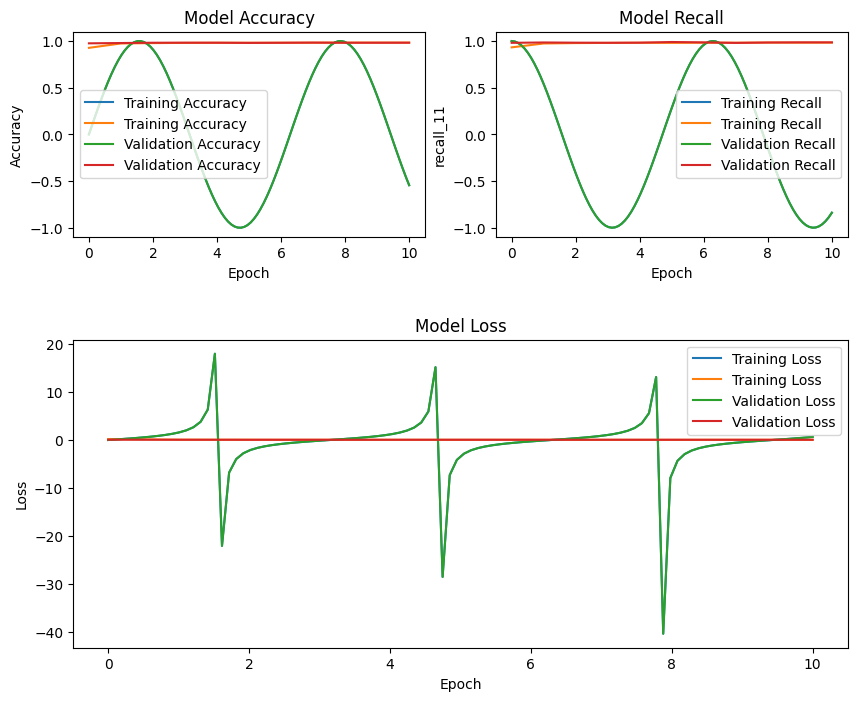

Évaluation du modèle...
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2280
           1       0.98      0.99      0.98      2372

    accuracy                           0.98      4652
   macro avg       0.98      0.98      0.98      4652
weighted avg       0.98      0.98      0.98      4652



In [ ]:
# représentation graphique du model
# Sample data
x = np.linspace(0, 10, 100)
y1, y2, y3 = np.sin(x), np.cos(x), np.tan(x)
# Create figure and grid
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])  # Adjust row heights if needed
# First row: Two plots (left and right)
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
# Second row: One plot spanning both columns
ax3 = fig.add_subplot(gs[1, :])  # Span across all columns in the second row
# Plot data

ax1.plot(x, y1, history.history['accuracy'], label='Training Accuracy')
ax1.plot(x, y1, history.history['val_accuracy'], label='Validation Accuracy')

ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()



ax2.plot(x, y2, history.history['recall_11'], label='Training Recall')
ax2.plot(x, y2, history.history['val_recall_11'], label='Validation Recall')
ax2.set_title('Model Recall')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('recall_11')
ax2.legend()

ax3.plot(x, y3, history.history['loss'], label='Training Loss')
ax3.plot(x, y3, history.history['val_loss'], label='Validation Loss')
ax3.set_title('Model Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
# Adjust spacing between rows
plt.subplots_adjust(hspace=0.4)  # Space between rows
plt.show()

# Évaluation du modèle
print("Évaluation du modèle...")
y_pred = model.predict(X_val_features, verbose=0)
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

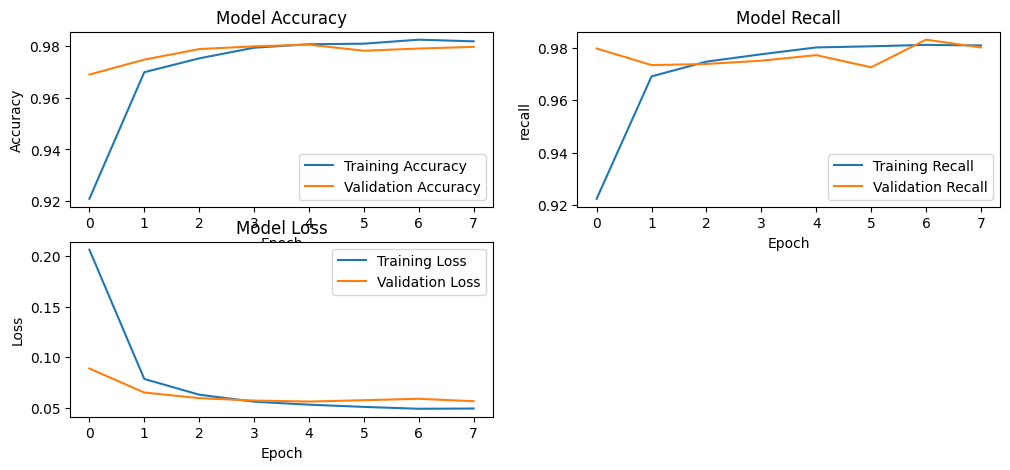

Évaluation du modèle...
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2280
           1       0.96      0.99      0.98      2372

    accuracy                           0.98      4652
   macro avg       0.98      0.98      0.98      4652
weighted avg       0.98      0.98      0.98      4652



In [25]:
# représentation graphique du model
plt.figure(figsize=(12, 5))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')


plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')



plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
# Évaluation du modèle
print("Évaluation du modèle...")
y_pred = model.predict(X_val_features, verbose=0)
y_pred_class =(y_pred > 0.2).astype(int)
print(classification_report(y_val, y_pred_class))

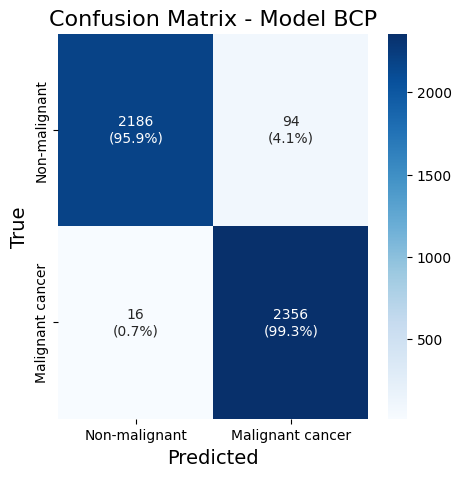

In [26]:
# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(cm, model_name):
    plt.figure(figsize=(5, 5))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

    # Annotate with both raw numbers and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=["Non-malignant", "Malignant cancer"], yticklabels=["Non-malignant", "Malignant cancer"])
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred_class)

# Plot the confusion matrix with percentages
plot_confusion_matrix_with_percentages(cm, "Model BCP")

In [ ]:
def predictImage(url, feature_extractor, model):
    '''
    Prédit la classe d'une image avec le modèle edRVFL

    Arguments:
        url: chemin vers l'image
        feature_extractor: modèle d'extraction de caractéristiques VGG16
        model: modèle edRVFL entraîné
    '''
    # Charger et prétraiter l'image
    img = load_img(url, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array.reshape((-1, 224, 224, 3))

    # Prétraiter l'image pour VGG16
    img_array = preprocess_input(img_array)

    # Extraire les caractéristiques avec le feature_extractor
    features = feature_extractor.predict(img_array, verbose=0)

    # Faire la prédiction avec le modèle edRVFL
    res = model.predict(features, verbose=0)[0][0]

    # Interpréter le résultat
    if res < 0.5:
        diagnostic = "Négatif"  # Ajustez selon vos classes
        prob = 1 - res
    else:
        diagnostic = "Positif"   # Ajustez selon vos classes
        prob = res

    # Afficher l'image avec le résultat
    plt.figure(figsize=(6, 6))
    plt.imshow(array_to_img(img_to_array(img)))
    plt.axis("off")
    plt.title(f"{diagnostic}", fontsize=14)

    return plt.show()

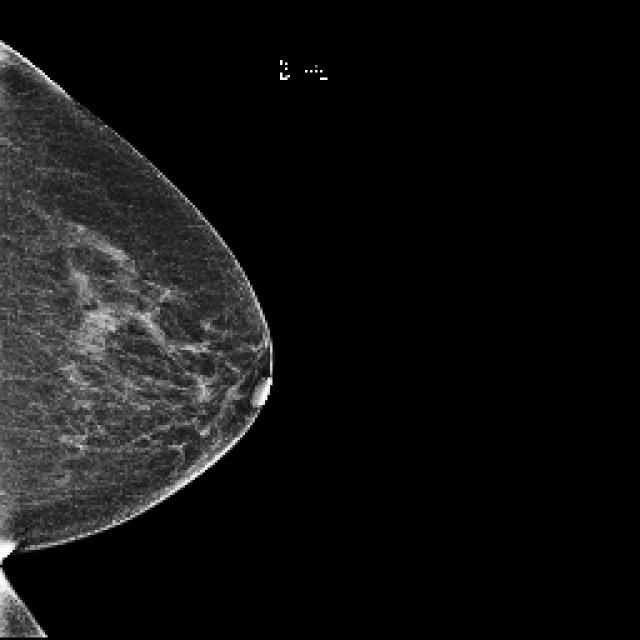

In [ ]:
load_img("/content/data/Deep_learning/test/1/1025_773597682_png.rf.10eef608772845290c0ed1c5dc80c3ac.jpg")

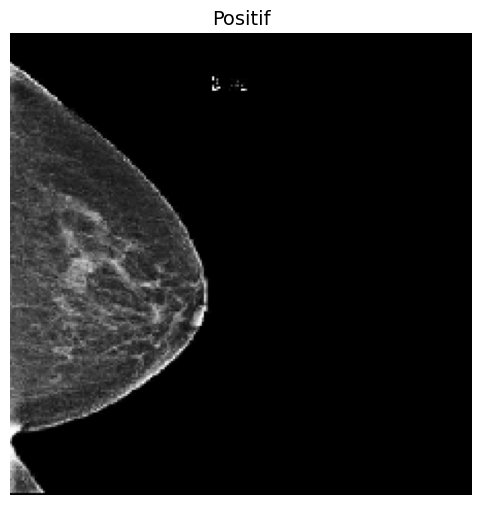

In [ ]:
predictImage("/content/data/Deep_learning/test/1/1025_773597682_png.rf.10eef608772845290c0ed1c5dc80c3ac.jpg", feature_extractor, model)

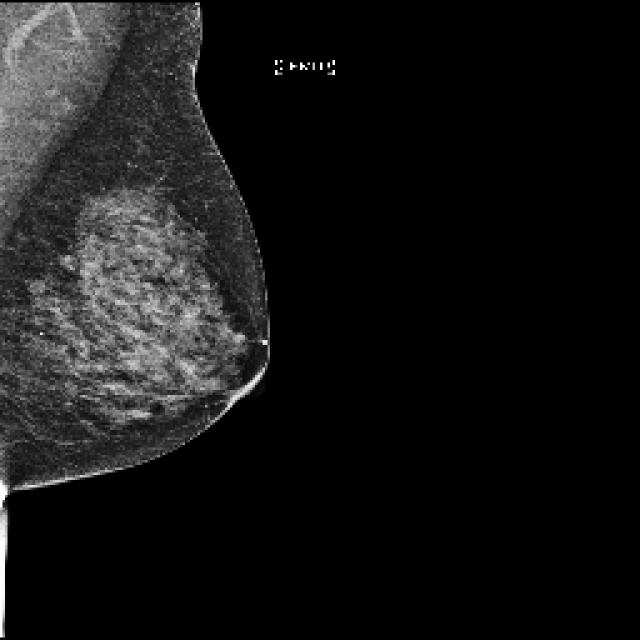

In [ ]:
load_img("/content/data/Deep_learning/test/0/1588_1603972171_png.rf.29f8eb427de2e92c2222298b7b497ad0.jpg")

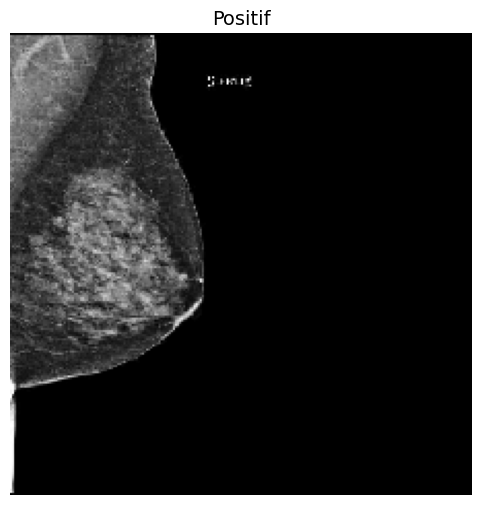

In [ ]:
predictImage("/content/data/Deep_learning/test/0/1588_1603972171_png.rf.29f8eb427de2e92c2222298b7b497ad0.jpg", feature_extractor, model)

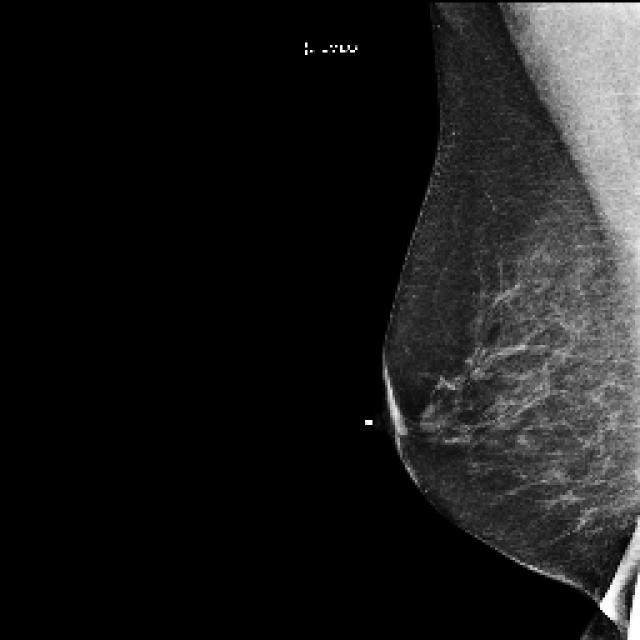

In [ ]:
load_img("/content/data/Deep_learning/test/0/1649_1117924917_png.rf.8256b936a9d187da0807adc99545ee08.jpg")

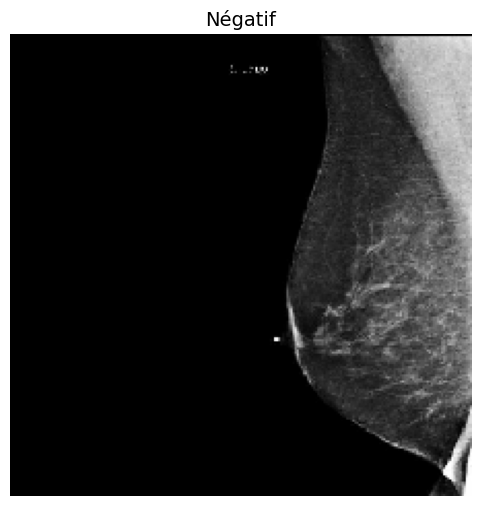

In [ ]:
predictImage("/content/data/Deep_learning/test/0/1649_1117924917_png.rf.8256b936a9d187da0807adc99545ee08.jpg", feature_extractor, model)

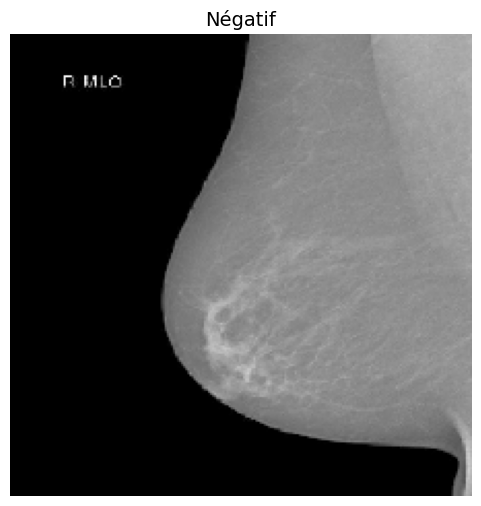

In [ ]:
predictImage("/content/data/Deep_learning/test/0/1937_1609639929_png.rf.d7f6fd8bad84ca7e44c6ff58b9a57751.jpg", feature_extractor, model)

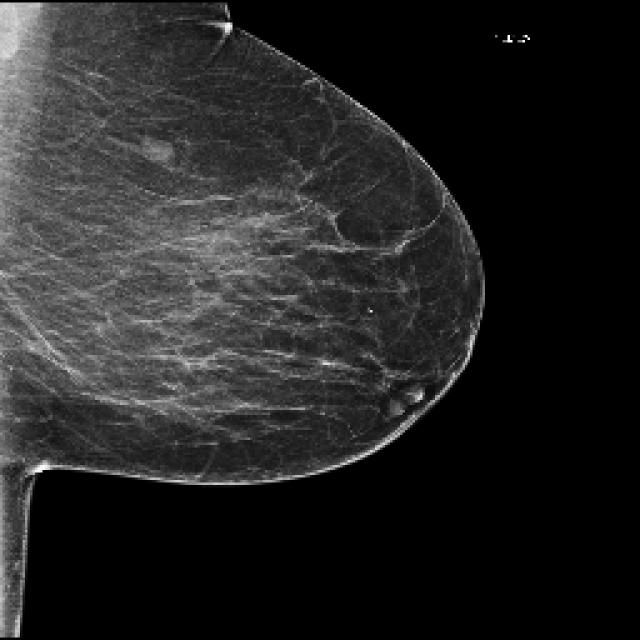

In [ ]:
load_img("/content/data/Deep_learning/test/1/15696_891457301_png.rf.e3fe46334d6e10ead692a563a9a8d298.jpg")

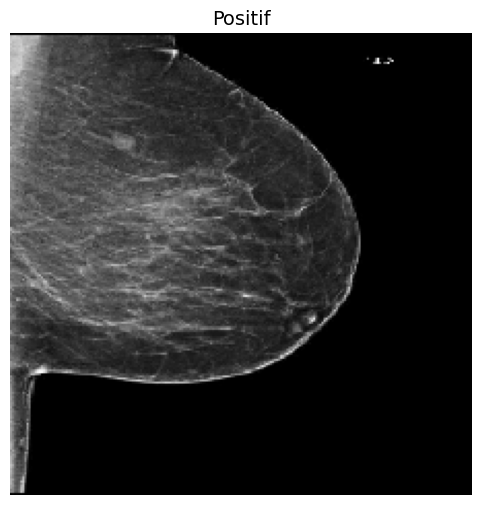

In [ ]:
predictImage("/content/data/Deep_learning/test/1/15696_891457301_png.rf.e3fe46334d6e10ead692a563a9a8d298.jpg", feature_extractor, model)

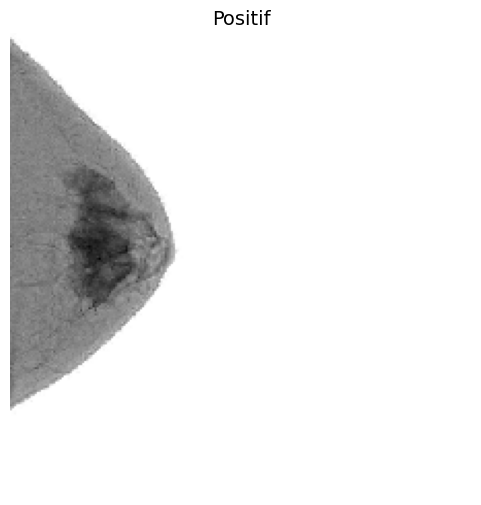

In [ ]:
predictImage("/content/data/Deep_learning/test/1/17562_104106029_png.rf.f416fe1e6bf76fa600a4558f93af491b.jpg", feature_extractor, model)

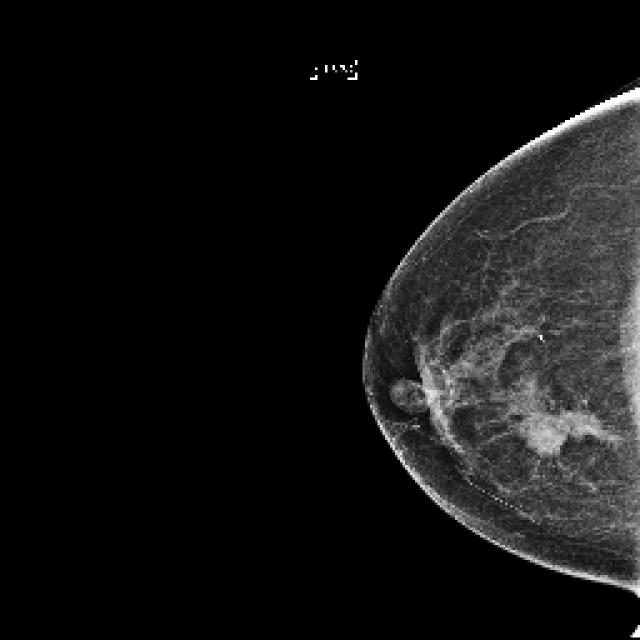

In [ ]:
load_img("/content/data/Deep_learning/test/1/22860_2025091558_png.rf.7fbd34c60ae622ec9b172cbdfed9a706.jpg")

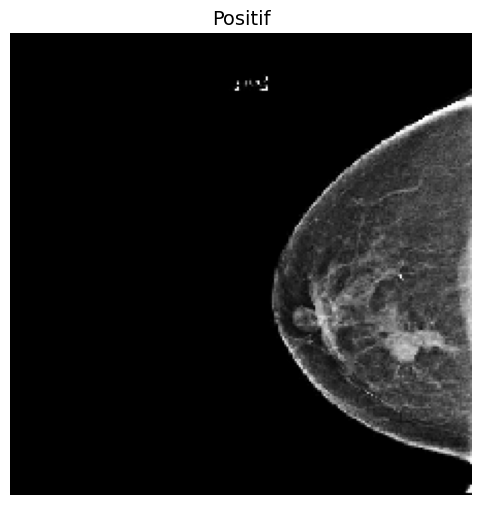

In [ ]:
predictImage("/content/data/Deep_learning/test/1/22860_2025091558_png.rf.7fbd34c60ae622ec9b172cbdfed9a706.jpg", feature_extractor, model)

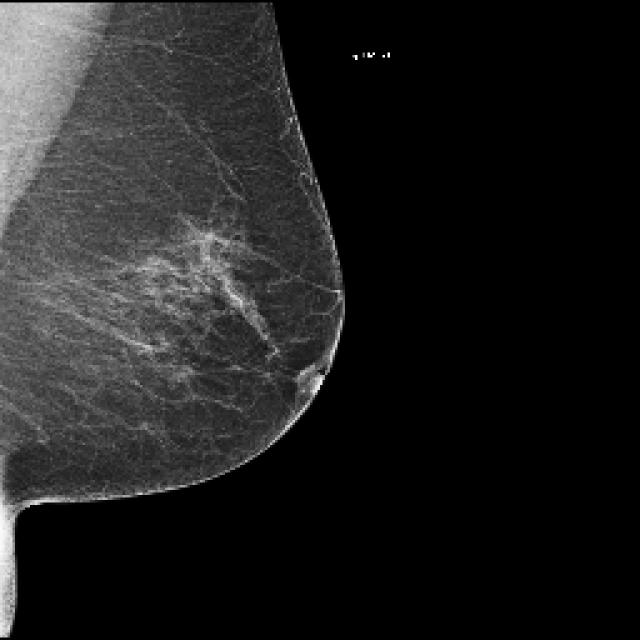

In [ ]:
load_img("/content/data/Deep_learning/test/0/2266_934886864_png.rf.19c776702a3d80ae0b0900e9cb487492.jpg")

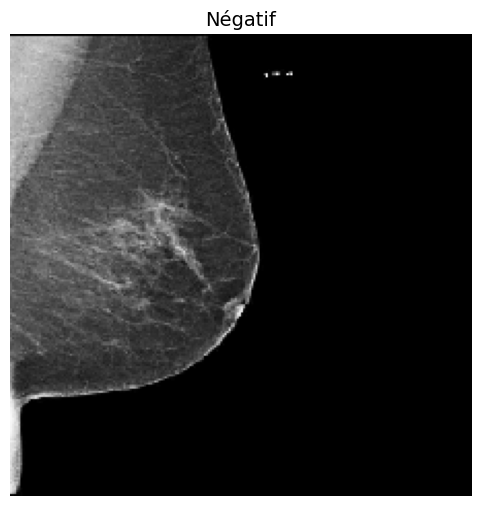

In [ ]:
predictImage("/content/data/Deep_learning/test/0/2266_934886864_png.rf.19c776702a3d80ae0b0900e9cb487492.jpg", feature_extractor, model)

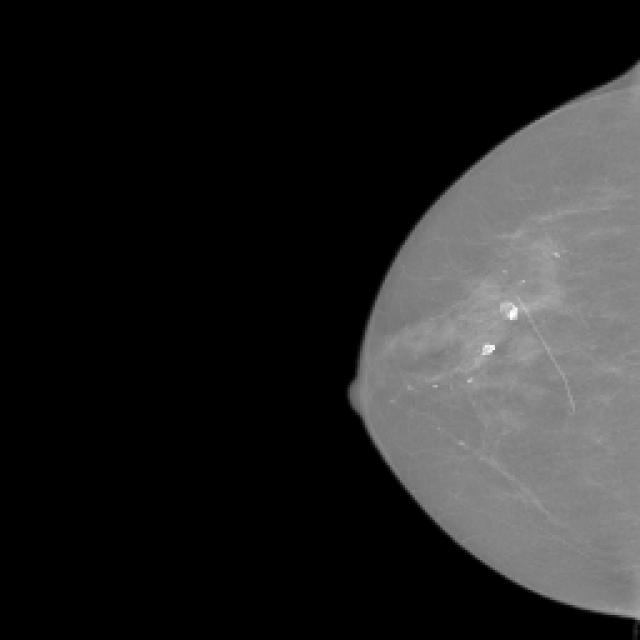

In [ ]:
load_img("/content/data/Deep_learning/test/0/2454_378643240_png.rf.fc43aef0bf939ccf336181b89375e18f.jpg")

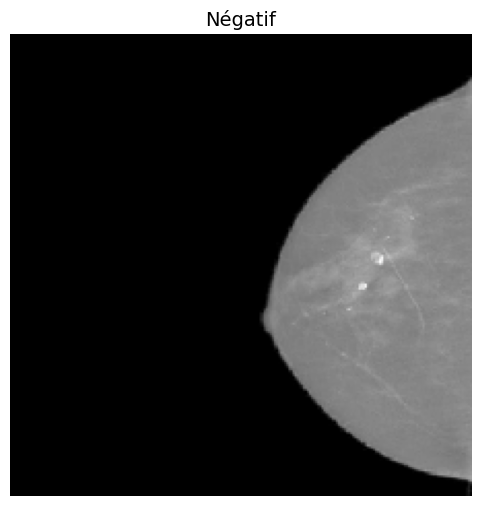

In [ ]:
predictImage("/content/data/Deep_learning/test/0/2454_378643240_png.rf.fc43aef0bf939ccf336181b89375e18f.jpg", feature_extractor, model)

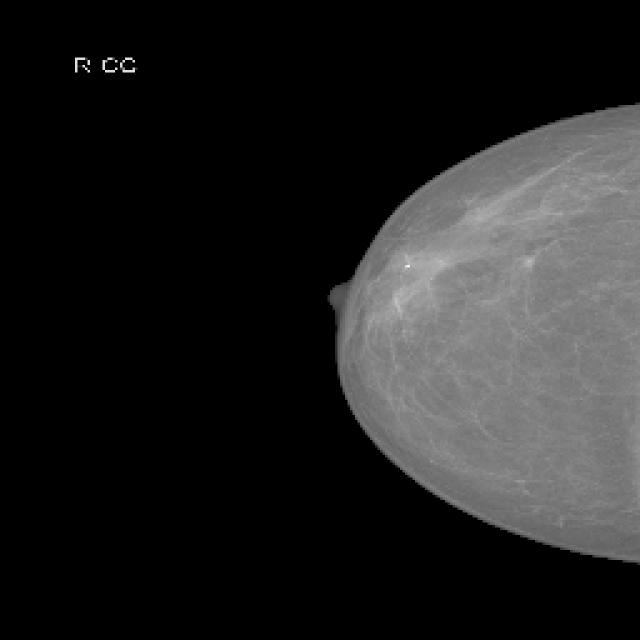

In [ ]:
load_img("/content/data/Deep_learning/test/0/2494_413498453_png.rf.32777e562e078f8f587730b0747b03ea.jpg")

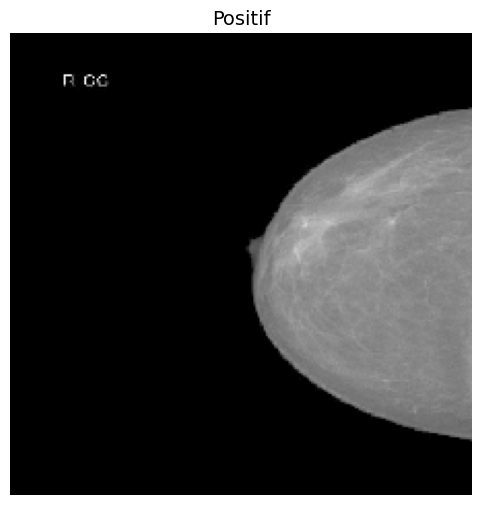

In [ ]:
predictImage("/content/data/Deep_learning/test/0/2494_413498453_png.rf.32777e562e078f8f587730b0747b03ea.jpg", feature_extractor, model)

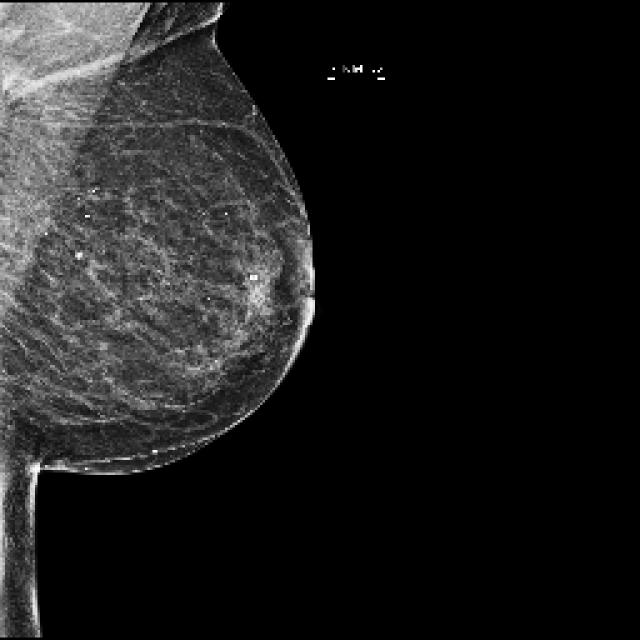

In [ ]:
load_img("/content/data/Deep_learning/test/1/25323_396189007_png.rf.d40d6d4f7d20ee943029cb5163a30a83.jpg")

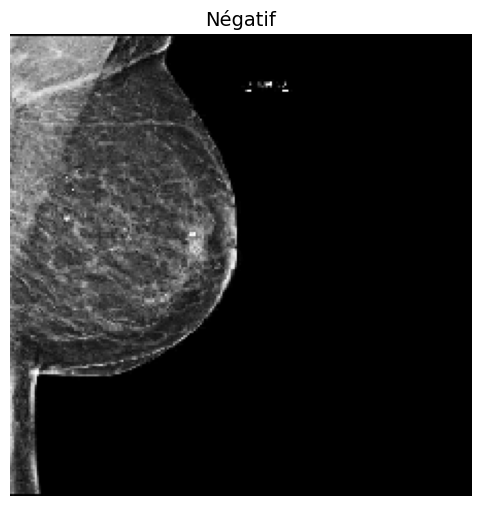

In [ ]:
predictImage("/content/data/Deep_learning/test/1/25323_396189007_png.rf.d40d6d4f7d20ee943029cb5163a30a83.jpg", feature_extractor, model)

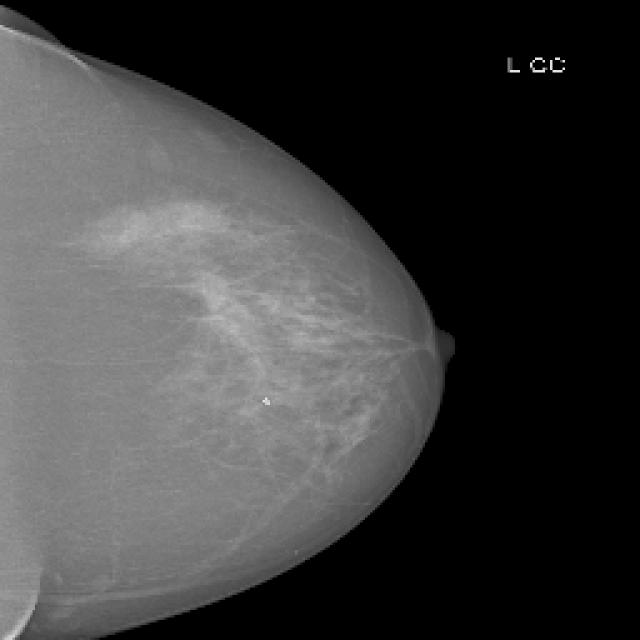

In [ ]:
load_img("/content/data/Deep_learning/test/1/28996_1922679376_png.rf.9b0cbb183acfde2492cf8eb4a7001458.jpg")

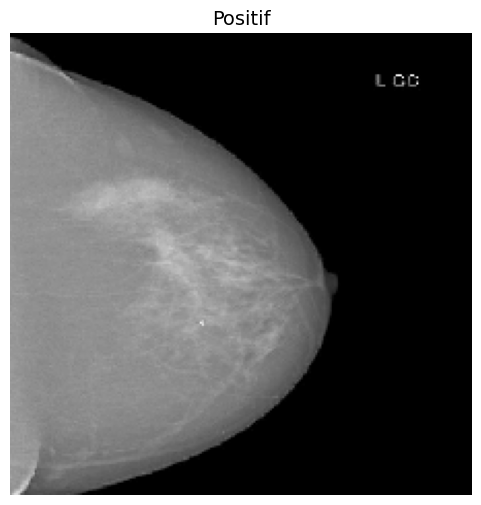

In [ ]:
predictImage("/content/data/Deep_learning/test/1/28996_1922679376_png.rf.9b0cbb183acfde2492cf8eb4a7001458.jpg", feature_extractor, model)